### **6.6: Sourcing & Analyzing Time Series Data**

### **Contents**
1. Importing libraries & data
2. Preparing time-series data
3. Time series analysis: decomposition
4. Testing for stationarity
5. Stationarizing
6. Bonus Task

### **1. Importing Libraries & Data**

**- Importing Libraries**

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [2]:
pip install --upgrade numpy

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Option to ensure to display in the notebook without the need to "call" them specifically.

%matplotlib inline

**- Importing Data**

In [4]:
# Create data path
path = r'/Users/anjanpakhrin/Documents/US Accidents Analysis 2016-2023/02 Data'

In [5]:
# Import modified data from previous exercise as pickle
df = pd.read_pickle(os.path.join(path, 'Prepared Data', 'us_accidents_6-5.pkl'))

**- Basic checks for dataframe**

In [6]:
# Quick data check
df.head()

,id,source,severity,start_time,end_time,distance(mi),state,temperature(f),wind_chill(f),humidity(%),...,day_of_week,accident_day,accident_hour,time_of_day,severity_label,extreme_flag,year,clusters,date,cluster
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,0.01,Ohio,36.900002,0.000000,91.0,...,0,Monday,5,Night,Serious,False,2016,0,2016-02-08,blue
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,0.01,Ohio,37.900002,0.000000,100.0,...,0,Monday,6,Morning,Moderate,False,2016,0,2016-02-08,blue
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,0.01,Ohio,36.000000,33.299999,100.0,...,0,Monday,6,Morning,Moderate,False,2016,0,2016-02-08,blue
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,0.01,Ohio,35.099998,31.000000,96.0,...,0,Monday,7,Morning,Serious,False,2016,0,2016-02-08,blue
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,0.01,Ohio,36.000000,33.299999,89.0,...,0,Monday,7,Morning,Moderate,False,2016,0,2016-02-08,blue


In [7]:
# Check data shape
df.shape

(7477440, 32)

In [8]:
# Check columns of df
df.columns

Index(['id', 'source', 'severity', 'start_time', 'end_time', 'distance(mi)',
       'state', 'temperature(f)', 'wind_chill(f)', 'humidity(%)',
       'pressure(in)', 'visibility(mi)', 'wind_direction', 'wind_speed(mph)',
       'precipitation(in)', 'weather_condition', 'sunrise_sunset',
       'civil_twilight', 'nautical_twilight', 'astronomical_twilight', 'month',
       'month_name', 'day_of_week', 'accident_day', 'accident_hour',
       'time_of_day', 'severity_label', 'extreme_flag', 'year', 'clusters',
       'date', 'cluster'],
      dtype='object')

### **2. Preparing Time-Series Data**

**Since dataset has been already cleaned and wrangled no further steps are required.**

**- Accident counts by year**

In [9]:
# Accidetn coutns by year
accident_counts = df['year'].value_counts().sort_index()

print("Observations by Year")
print(accident_counts)
print(f"\nTotal years: {len(accident_counts)}")
print(f"Total observations: {accident_counts.sum()}")

Observations by Year
year
2016     410572
2017     717091
2018     891850
2019     953620
2020    1178573
2021    1563462
2022    1762272
Name: count, dtype: int64

Total years: 7
Total observations: 7477440


**- Plotting Line Chart**

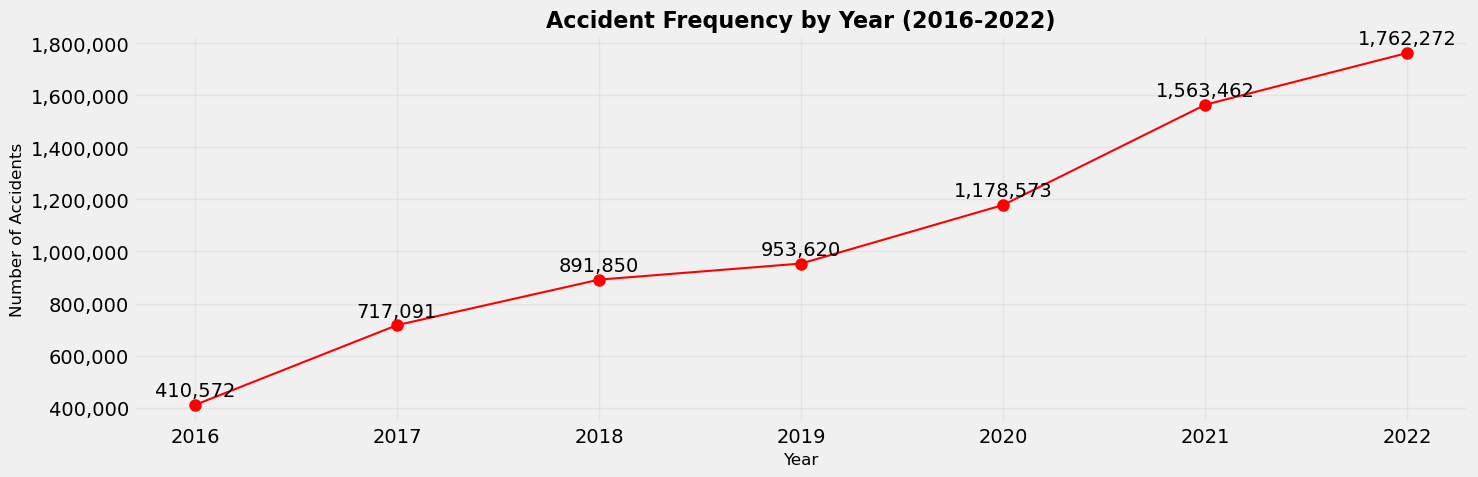

In [10]:
# Create line chart
plt.figure(figsize=(15, 5), dpi=100)
plt.plot(accident_counts.index, accident_counts.values,
        marker='o',
        linewidth=1.5,
        markersize=8,
        color='red')

# Add value lables
for year, count in accident_counts.items():
    plt.text(year, count + max(accident_counts.values)*0.01, 
             f'{count:,.0f}', ha='center', va='bottom')

# Labeling
plt.title('Accident Frequency by Year (2016-2022)', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Accidents', fontsize=12)

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
plt.grid(True, alpha=0.3)

# Ensure all years are shown
plt.xticks(accident_counts.index)
plt.tight_layout()

# Show plot
plt.show()

### **3. Time Series Analysis: Decomposition**

**Trend:** 
* **The line chart,** as illustrated above, shows the monotonic increase in recorded road accidents over the seven-year observation period. The data above indicates an approximate 329% growth in accident occurences, escalating from 410,572 incidents in 2016 to 1,762,272 incidents in 2022.
* The trend shows no signs of plateauing or reversal, indicating persistent underlying factors driving accident frequency.
* The slope appears to steepen in later years (2020-2022), which could suggest either compouding risk factors or improved reporting systems capturing more incidents.

**Seasonality:**
To be able to observe the seasonality of incidents, time series with monthly frequency is required.

In [11]:
# Sorting to insure proper time-series
df_sorted = df.sort_values('start_time')

# Create monthly time series for better decompostion
monthly_accidents = df_sorted.set_index('start_time').resample('M').size()

In [12]:
# Decompose the time series using an additive model
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = sm.tsa.seasonal_decompose(monthly_accidents, model='additive', period=12)

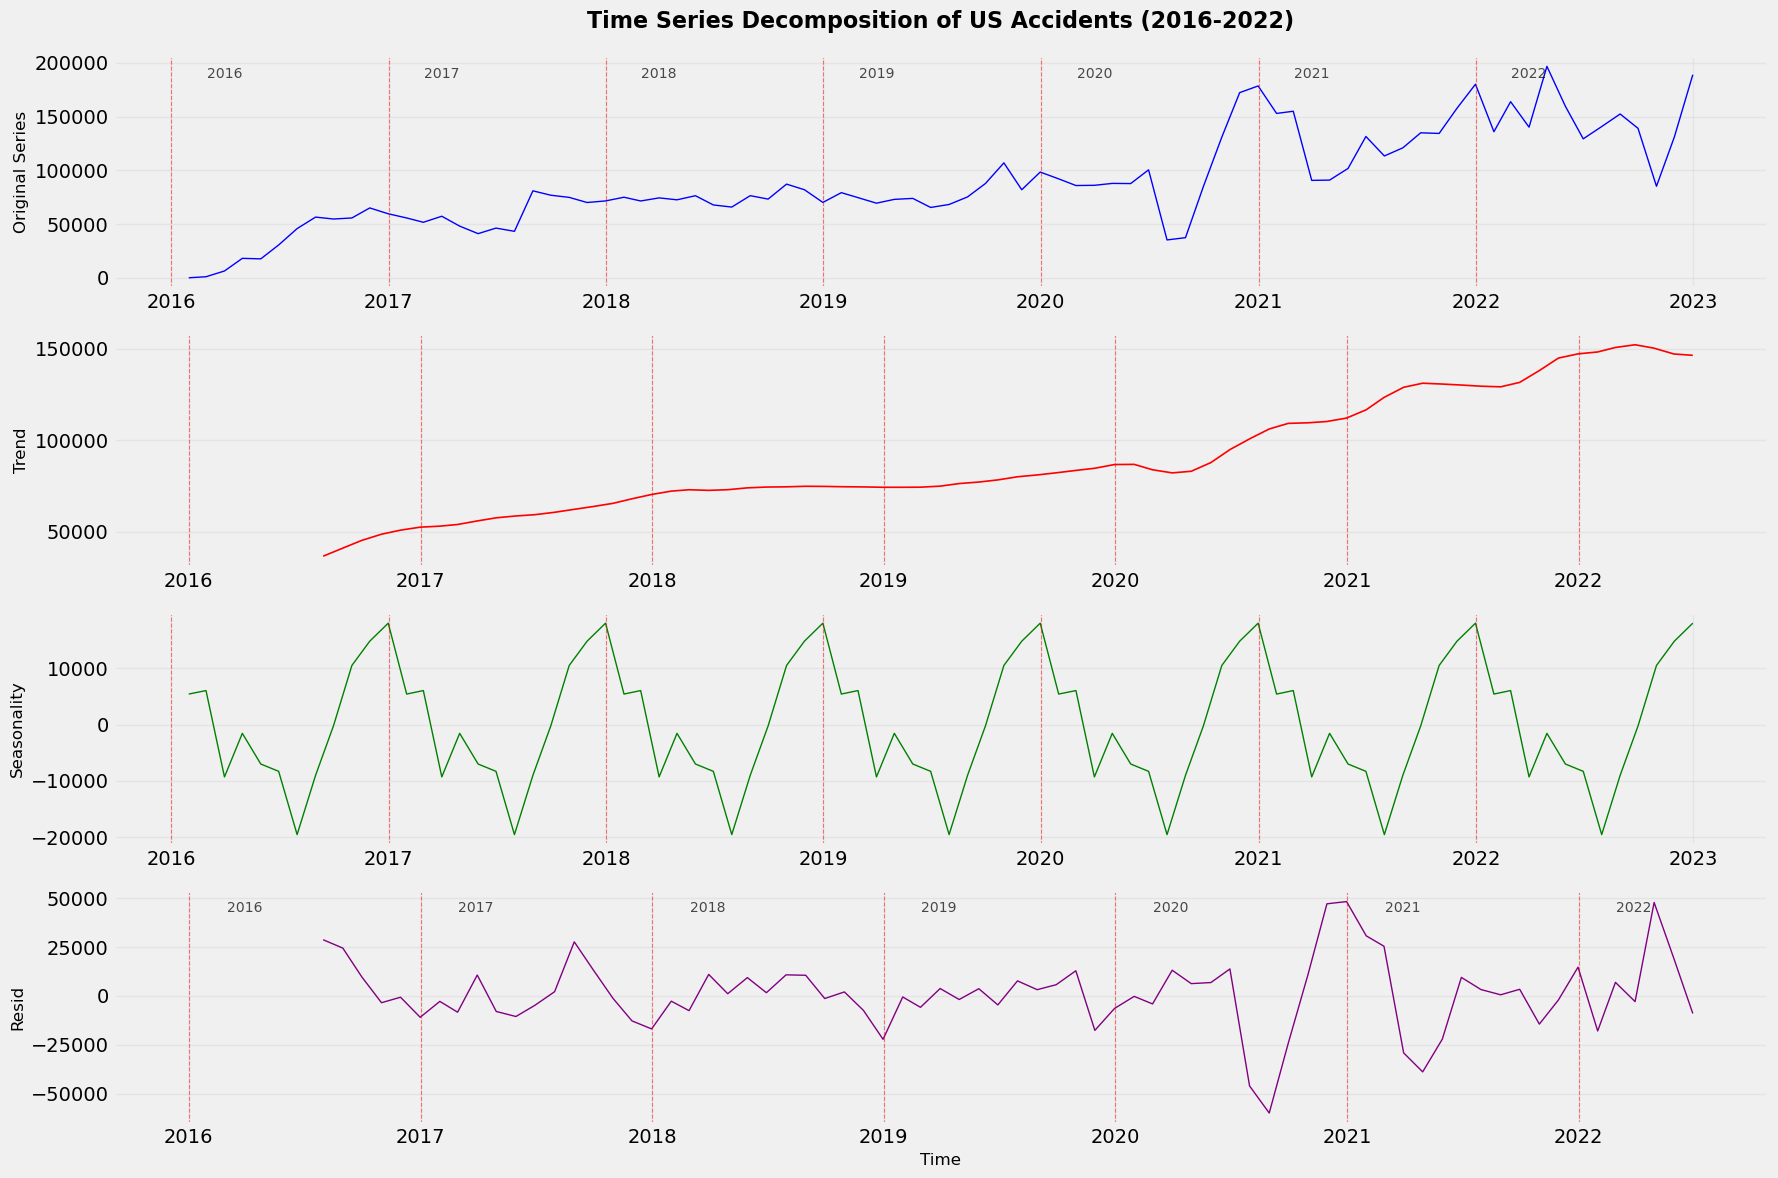

In [13]:
# This will define a fixed size for all special charts.
from pylab import rcParams
rcParams['figure.figsize'] = 18, 12

# Create the decomposition plot with year markers and reduced linewidth
fig, axes = plt.subplots(4, 1, figsize=(18, 12))

# Original Series
axes[0].plot(monthly_accidents.index, monthly_accidents.values, 
            color='blue', linewidth=1.0)
axes[0].set_title('Time Series Decomposition of US Accidents (2016-2022)', 
                 fontsize=16, fontweight='bold', pad=20)
axes[0].set_ylabel('Original Series', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Add year markers for original series
for year in range(2016, 2023):
    axes[0].axvline(pd.Timestamp(f'{year}-01-01'), color='red', 
                   linestyle='--', alpha=0.5, linewidth=0.8)
    axes[0].text(pd.Timestamp(f'{year}-03-01'), axes[0].get_ylim()[1]*0.9, 
                str(year), fontsize=10, alpha=0.7)

# Trend Component
axes[1].plot(decomposition.trend.index, decomposition.trend.values, 
            color='red', linewidth=1.2)
axes[1].set_ylabel('Trend', fontsize=12)
axes[1].grid(True, alpha=0.3)

# Add year markers for trend
for year in range(2016, 2023):
    axes[1].axvline(pd.Timestamp(f'{year}-01-01'), color='red', 
                   linestyle='--', alpha=0.5, linewidth=0.8)

# Seasonal Component
axes[2].plot(decomposition.seasonal.index, decomposition.seasonal.values, 
            color='green', linewidth=1.0)
axes[2].set_ylabel('Seasonality', fontsize=12)
axes[2].grid(True, alpha=0.3)

# Add year markers for seasonal
for year in range(2016, 2023):
    axes[2].axvline(pd.Timestamp(f'{year}-01-01'), color='red', 
                   linestyle='--', alpha=0.5, linewidth=0.8)

# Residual Component
axes[3].plot(decomposition.resid.index, decomposition.resid.values, 
            color='purple', linewidth=1.0)
axes[3].set_ylabel('Resid', fontsize=12)
axes[3].set_xlabel('Time', fontsize=12)
axes[3].grid(True, alpha=0.3)

# Add year markers for residual
for year in range(2016, 2023):
    axes[3].axvline(pd.Timestamp(f'{year}-01-01'), color='red', 
                   linestyle='--', alpha=0.5, linewidth=0.8)
    axes[3].text(pd.Timestamp(f'{year}-03-01'), axes[3].get_ylim()[1]*0.8, 
                str(year), fontsize=10, alpha=0.7)

plt.tight_layout()
plt.show()

* **Original Series:** Shows overall US accident counts (aggregated by month). A significant increase is observed from late 2020, following a dip in early 2020.
* **Trend:** Reveals a steady, slow increase in accidents (aggregated by year) from 2016 to mid-2020, accelerating sharply upwards from mid-2020 to early 2023.
* **Seasonality:** Displays consistent annual patterns, with regular peaks and troughs in accident numbers each year.
* **Residuals:** Represents unexplained variations. Shows a notable dip in early 2020 and more pronounced fluctuations in 2021-2022, suggesting other influencing factors.

**Overall:** The most critical finding is the strong and accelerating upward trend in US accidents since mid-2020, superimposed on consistent seasonal patterns.

### **4. Testing for Stationarity**
**- Dickey-Fuller test**

In [14]:
# Import the adfuller() function
from statsmodels.tsa.stattools import adfuller

# Define the function
def dickey_fuller(timeseries):
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the monthly accident time series
dickey_fuller(monthly_accidents)

Dickey-Fuller Stationarity test:
Test Statistic                 -0.153969
p-value                         0.943791
Number of Lags Used            11.000000
Number of Observations Used    72.000000
Critical Value (1%)            -3.524624
Critical Value (5%)            -2.902607
Critical Value (10%)           -2.588679
dtype: float64


* **Null Hypothesis (H₀):** The time series has a unit root (it is non-stationary).
* **Alternative Hypothesis (H₁):** The time series does not have a unit root (it is stationary).

**Interpretation:** Since the **Test-Statstic (-0.153969)** is **greater than all Critical Values (1%: -3.524624, 5%: -2.902607, 10%: -2.588679)** and the **p-values (0.94)** is much **higher thatn 0.05 (5% significance level),** we **fail to reject the the null hypothesis.** 

**Conclusion:** The time-series is **non-stationary**, meaning its statistical properties (mean, variance, etc.) change over time. To achieve stationarity, differencing **(selected method in this exercise)** or other transformations may be required before modeling.

**- Autocorrelation**

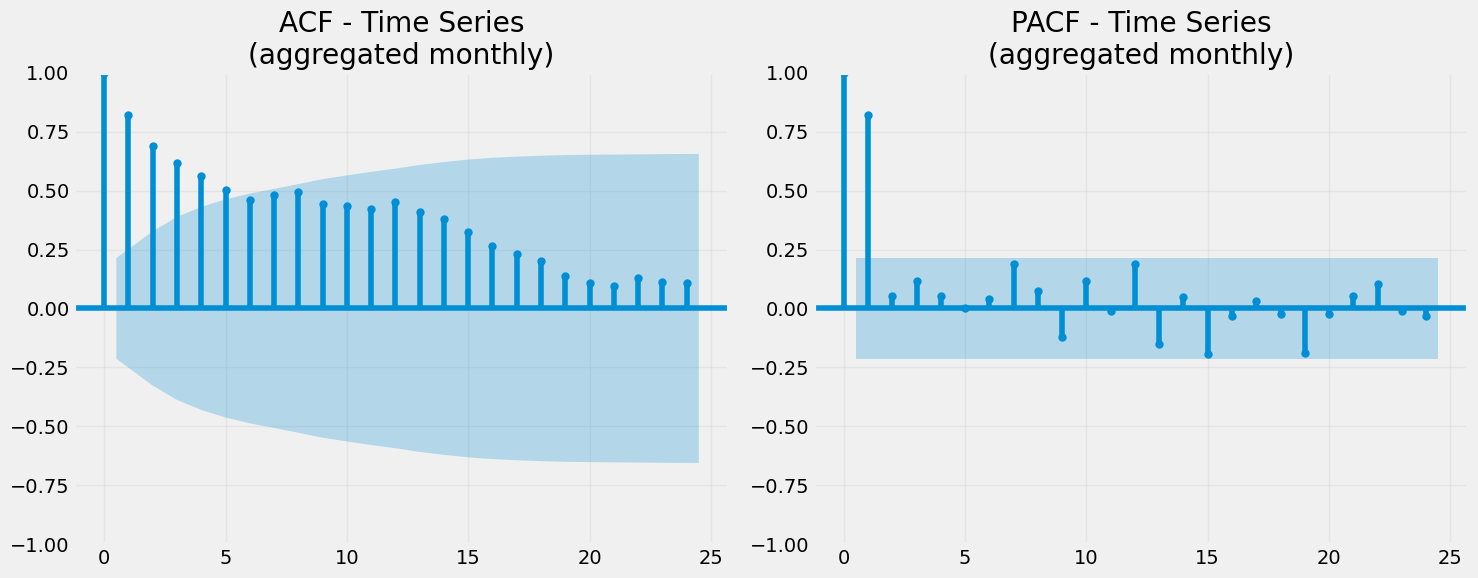

In [15]:
# Import the autocorrelation and partial correlation plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # acf: autocorrelation function, pacf: partial autocorrealation function

# Plot ACF and PACF for time-series
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plot_acf(monthly_accidents, lags=24, ax=plt.gca(), alpha=0.05)
plt.title('ACF - Time Series\n(aggregated monthly)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plot_pacf(monthly_accidents, lags=24, ax=plt.gca(), alpha=0.05)
plt.title('PACF - Time Series\n(aggregated monthly)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Interpretation:** 
* **ACF (Original Series - Aggregated per Month):**
   * Shows very slow decay with many significant positive lags.
   * Indicates a strong, persistent trend and high dependence on distant past values.
   * Confirms the **Dickey-Fuller test** --> time-series is non-stationary

* **PACF (Original Series - Aggregated per Month):**
   * Features a very strong, significant spike at lag 1.
   * Shows a rapid drop-off in significance for subsequent lags.
   * Suggests that the direct influence is primarily from the immediately preceding value, with longer-term correlations being largely indirect.

* **Overall:** Both plots strongly confirm that the time series is non-stationary, primarily due to the presence of a trend.

### **5. Stationarizing**

**- Differencing**

In [16]:
# Performing first-order differrencing with shift method --> value (new) = t - (t - 1)
monthly_diff = monthly_accidents - monthly_accidents.shift(1)

print("=== DIFFERENCING RESULTS ===")
print("Time series (first 5 values):")
print(monthly_accidents.head())
print("\nShifted Time series (first 5 values):")
print(monthly_accidents.shift(1).head())
print("\nDifferenced Time series (first 5 values):")
print(monthly_diff.head())

print(f"\nTime series length: {len(monthly_accidents)}")
print(f"Differenced Time series length: {len(monthly_diff.dropna())} (after removing NaN)")

=== DIFFERENCING RESULTS ===
Time series (first 5 values):
start_time
2016-01-31        7
2016-02-29      985
2016-03-31     6330
2016-04-30    18088
2016-05-31    17610
Freq: ME, dtype: int64

Shifted Time series (first 5 values):
start_time
2016-01-31        NaN
2016-02-29        7.0
2016-03-31      985.0
2016-04-30     6330.0
2016-05-31    18088.0
Freq: ME, dtype: float64

Differenced Time series (first 5 values):
start_time
2016-01-31        NaN
2016-02-29      978.0
2016-03-31     5345.0
2016-04-30    11758.0
2016-05-31     -478.0
Freq: ME, dtype: float64

Time series length: 84
Differenced Time series length: 83 (after removing NaN)


**- Visualizing Differenced Time Series**

In [17]:
# Create the differenced series
monthly_diff = monthly_accidents.diff().dropna()
monthly_diff_clean = monthly_diff  # For consistency with previous code

print(f"Date range: {monthly_diff_clean.index.min()} to {monthly_diff_clean.index.max()}")

Date range: 2016-02-29 00:00:00 to 2022-12-31 00:00:00


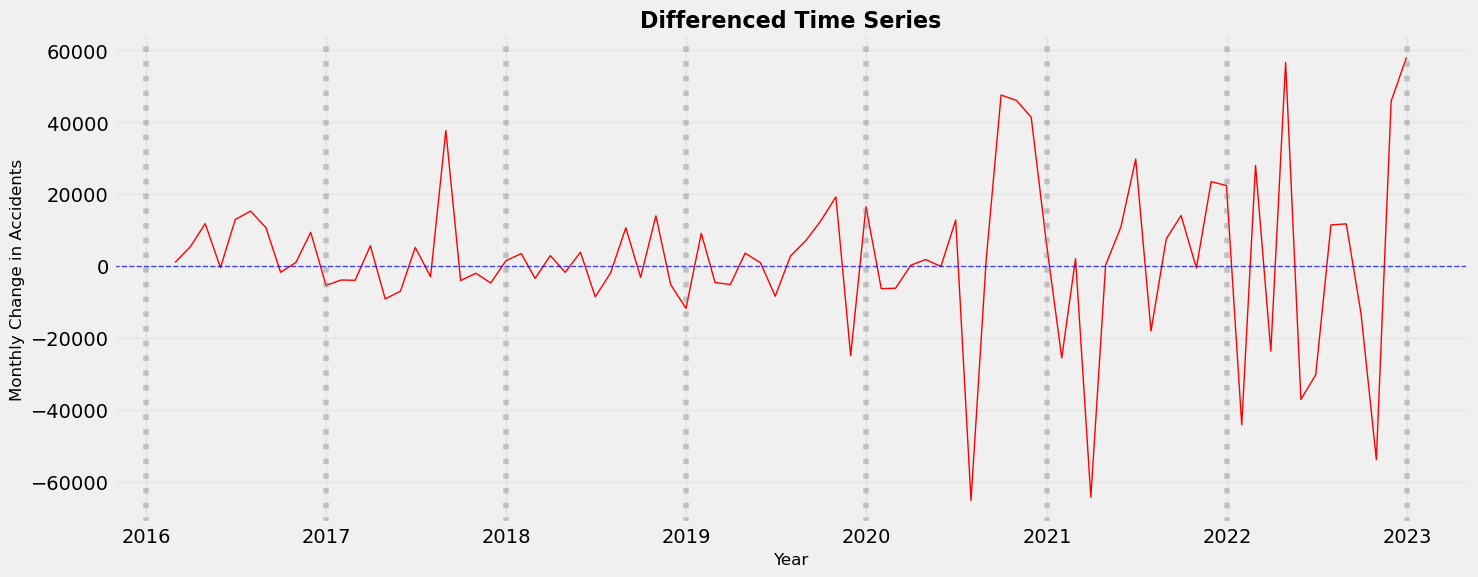

In [18]:
# Plot the differenced time series
plt.figure(figsize=(15, 6))
plt.plot(monthly_diff_clean.index, monthly_diff_clean.values, 
         color='red', linewidth=1)
plt.title('Differenced Time Series', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Monthly Change in Accidents', fontsize=12)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='blue', linestyle='--', linewidth=1, alpha=0.7)

# Add year markers
for year in range(2016, 2024):
    plt.axvline(pd.Timestamp(f'{year}-01-01'), color='gray', linestyle=':', alpha=0.4)

plt.tight_layout()
plt.show()

**- Dickey-Fuller Test for Differenced Time Series**

In [19]:
# Dickey-fuller test for differenced series
dickey_fuller(monthly_diff_clean)

Dickey-Fuller Stationarity test:
Test Statistic                 -5.095099
p-value                         0.000014
Number of Lags Used            12.000000
Number of Observations Used    70.000000
Critical Value (1%)            -3.527426
Critical Value (5%)            -2.903811
Critical Value (10%)           -2.589320
dtype: float64


* **Null Hypothesis (H₀):** The time series has a unit root (it is non-stationary).
* **Alternative Hypothesis (H₁):** The time series does not have a unit root (it is stationary).

**Interpretation:** Since the **Test-Statstic (-5.095099)** is significantly **less than all Critical Values (1%: -3.527426, 5%: -2.903811, 10%: -2.58932)** and the **p-values (0.000014)** is extremely small, significantly **less thatn common significance levels** like 0.01, 0.05, or 0.10, we **reject the the null hypothesis.** 

**Conclusion:** Based on both the comparison of the Test Statistic to the Critical Values and the very low p-value, we **reject the null hypothesis.** Therefore, it can be concluded that the **differenced time series is stationary.**

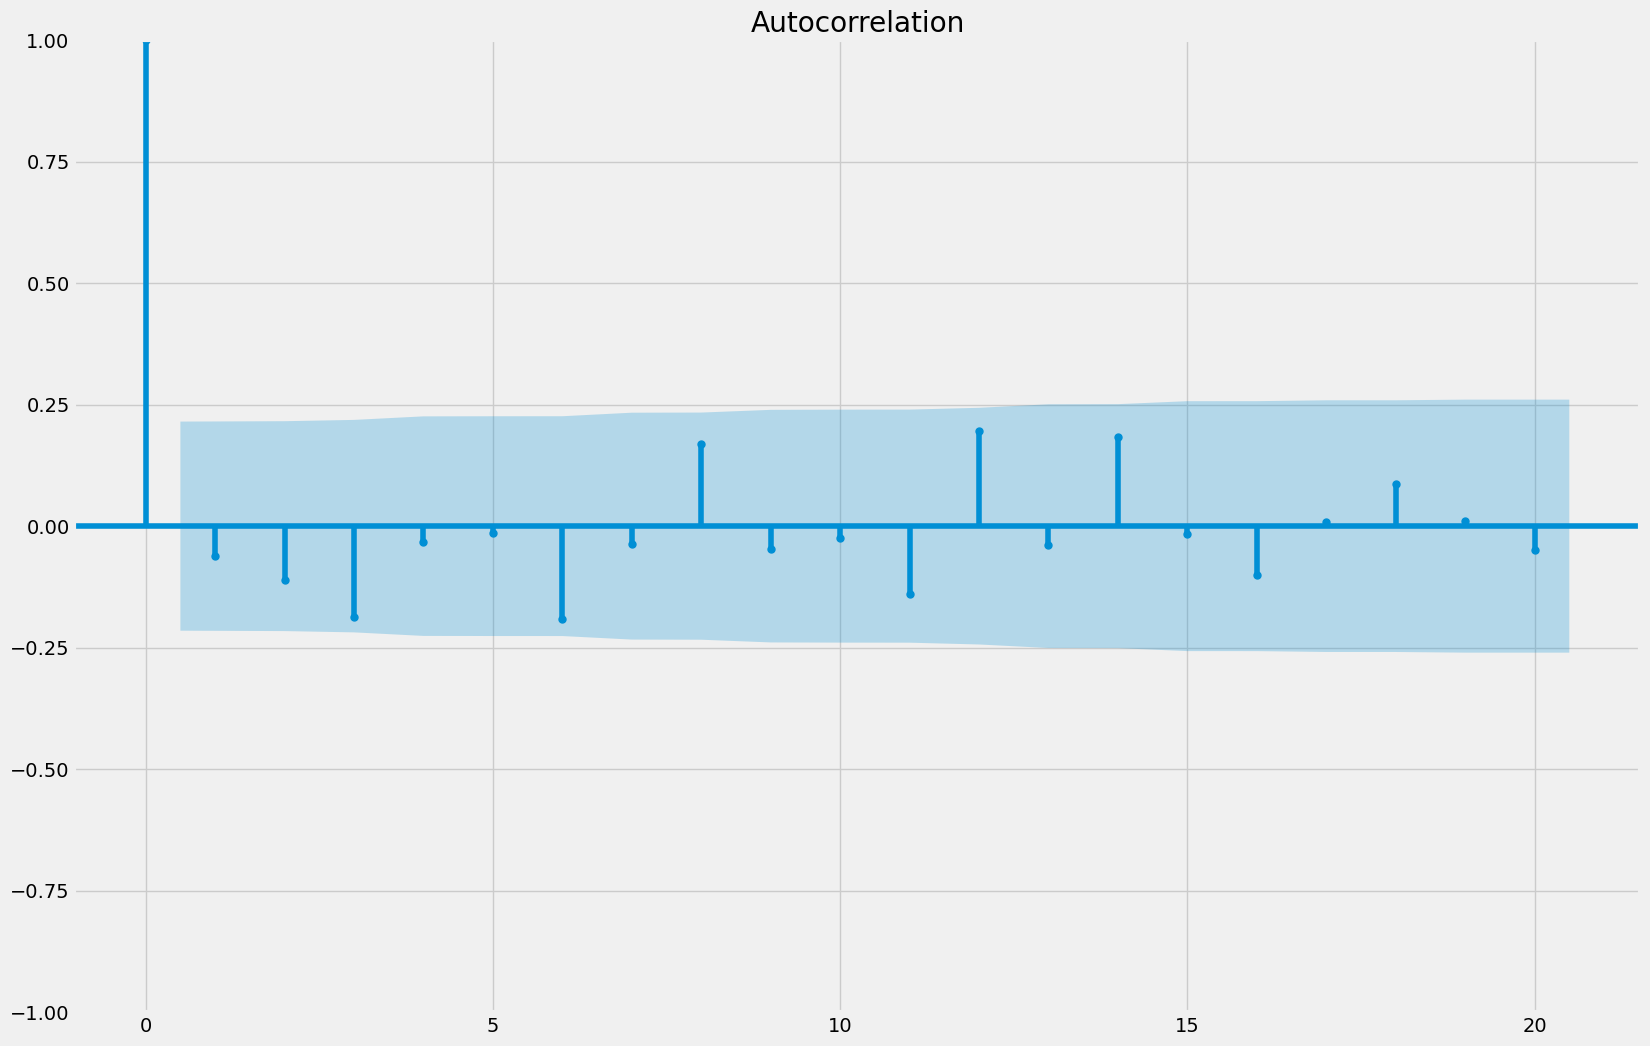

In [20]:
# Ploting Autocorrelation
plot_acf(monthly_diff_clean)
plt.show()

**Interpretation:** The **ACF plot** displays the correlations of the differenced time series with its own lagged values after **first differencing:**
* The **first lag** shows a strong spike, indicating a strong correlation between the differenced value at a time t and the differenced value at time t-1.
* Subsequent lags mostly fall **within the blue confidence interval**, indicating **no significant autocorrelations** beyond the first lag.
* This pattern suggests that **most of the trend has been removed** and **series is now likely stationary.**

### **6. Bonus Task**

In [21]:
# Import function
from statsmodels.tsa.arima.model import ARIMA

**- Split Data: Series**

In [22]:
# Split data (differenced time series) in train/test (80/20) proportion
# 80% for training; 20% for testing
train_size = int(len(monthly_diff_clean)*0.8)
train = monthly_diff_clean.iloc[:train_size]
test = monthly_diff_clean.iloc[train_size:]

In [23]:
# Display split data output
print("Train period:", train.index.min(), "→", train.index.max())
print("Test  period:", test.index.min(),  "→", test.index.max())
print("Train size:", len(train), " Test size:", len(test))

Train period: 2016-02-29 00:00:00 → 2021-07-31 00:00:00
Test  period: 2021-08-31 00:00:00 → 2022-12-31 00:00:00
Train size: 66  Test size: 17


**- Determine ARIMA parameters (p, d, q)**

<Figure size 1200x400 with 0 Axes>

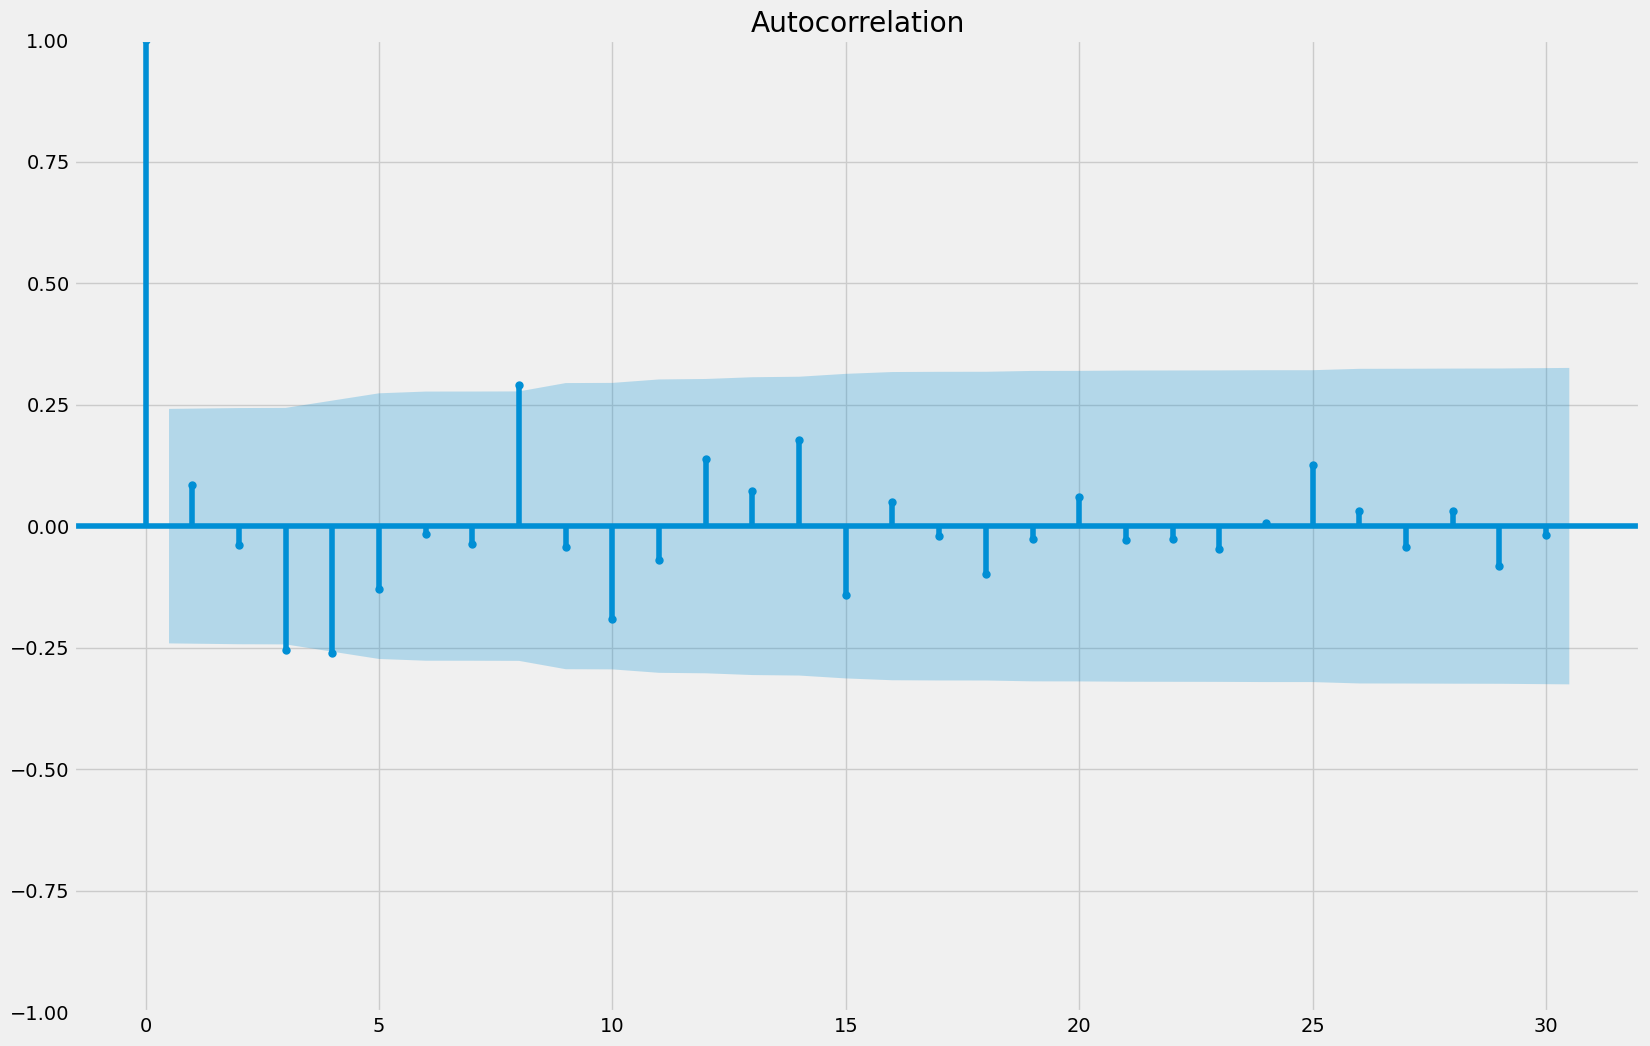

<Figure size 1200x400 with 0 Axes>

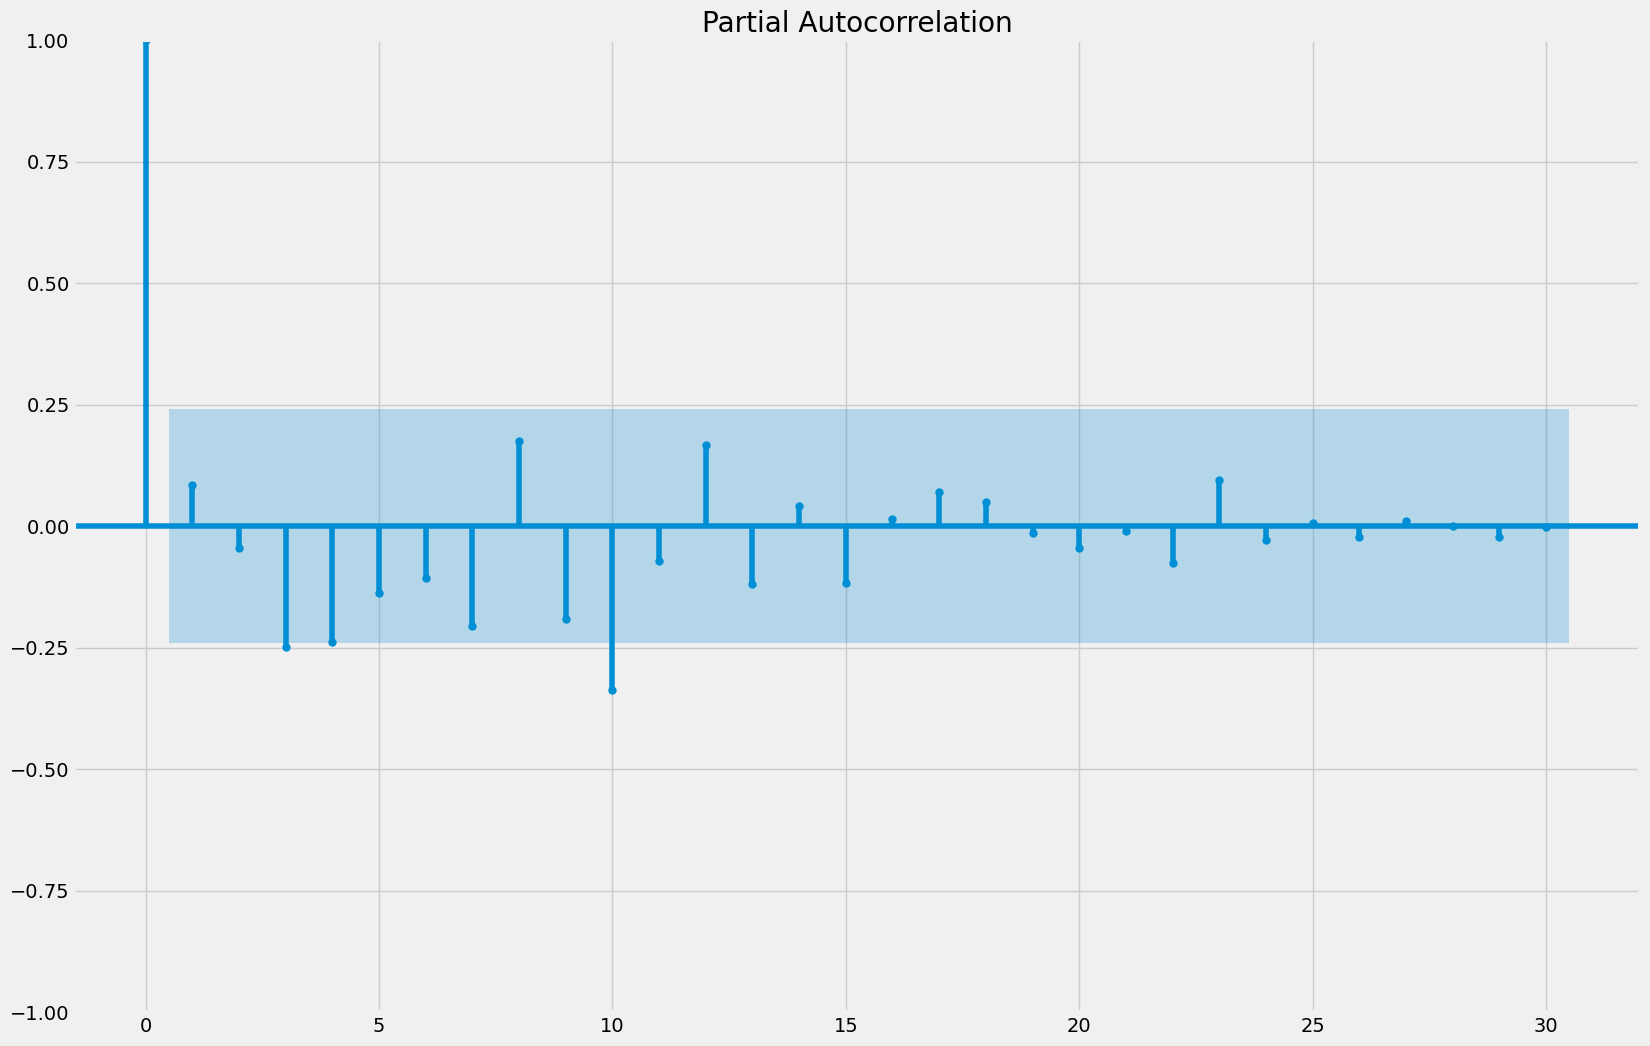

In [24]:
plt.figure(figsize=(12,4))
plot_acf(train, lags=30)
plt.show()

plt.figure(figsize=(12,4))
plot_pacf(train, lags=30, method='ywm')
plt.show()

**ARIMA parameters from above plots:**
* d = 1 (differenced once)
* ACF significant spike(s) → MA term(s) → q = 1
* PACF significant spike(s) → AR term(s) → p = 1

**- Fit theARIMA model**

In [25]:
# ARIMA (p=1, d=1, q=1)
model = ARIMA(train, order=(1, 1, 1))
fitted = model.fit()
pred_mean = fitted.forecast(steps=len(test))
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   66
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -733.280
Date:                Mon, 06 Oct 2025   AIC                           1472.560
Time:                        22:04:15   BIC                           1479.083
Sample:                    02-29-2016   HQIC                          1475.133
                         - 07-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0985      0.170      0.579      0.563      -0.235       0.432
ma.L1         -0.9827      0.143     -6.852      0.000      -1.264      -0.702
sigma2      4.893e+08   2.21e-10   2.21e+18      0.0

**- Forecasting**

In [26]:
# Forecast model
forecast = fitted.forecast(steps=len(test))

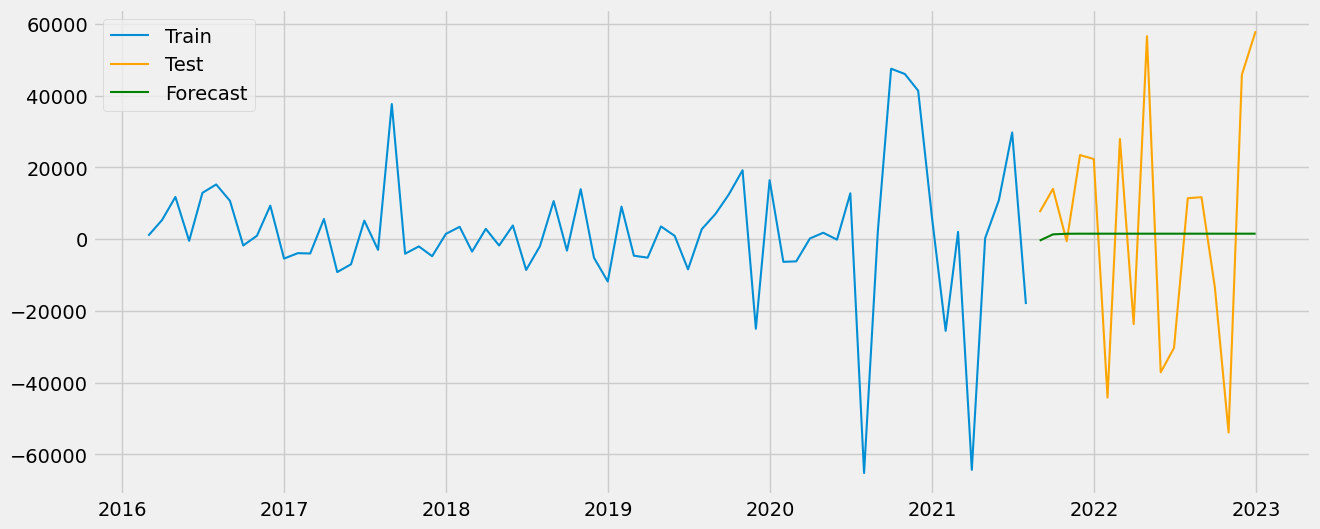

In [27]:
# Plot forecast
plt.figure(figsize=(14,6))
plt.plot(train, label='Train', linewidth=1.5)
plt.plot(test, label='Test', color='orange', linewidth=1.5)
plt.plot(forecast, label='Forecast', color='green', linewidth=1.5)
plt.legend()
plt.show()

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Evaluating model performance
mae  = mean_absolute_error(test, pred_mean)
rmse = np.sqrt(mean_squared_error(test, pred_mean))

print("MAE:", round(mae, 3))
print("RMSE:", round(rmse, 3))

MAE: 28191.79
RMSE: 33195.588


* **Forecast Accuracy:** The model's average prediction error ranges from ~28,192 (MAE) to ~33,196 (RMSE) accidents.
* **Next Steps:** Simplify the model (e.g., ARIMA(0,1,1)) by removing the non-significant AR(1) term to improve stability, and re-evaluate residual diagnostics (normality, heteroskedasticity).